Für die bessere Überischt importieren wir alles an einem Ort. Wir verwenden hier Keras V3, was theoretisch mit mehreren backend funktionieren könnte. Bei uns gab es aber Probleme bei dem Trainieren der Modelle mit Torch. Deshalb verwenden wir Tensorflow, leider ohne GPU Support auf Windows

In [22]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import layers
from livelossplot import PlotLossesKeras
from matplotlib import pyplot as plt


IMAGE_SIZE = (64, 64)
INPUT_SHAPE = (64, 64, 3)
BATCH_SIZE = 64

Mit der Funktion `image_dataset_from_directory` können wir die Bilddaten von der Festplatte laden. Dabei müssen sie in einem bestimmten Format sein. Ein Image Ordner mit jeweils einem Ordner für jede Klasse. Hier werden auch direkt die Batches erstellt, die Bilder gepadded auf eine gemeinsame Grösse und ein Validation/Trian Split erstellt.

In [23]:
_data_dir = os.path.join("data", "images")
_entries = os.listdir(_data_dir)
_folder_count = sum(os.path.isdir(os.path.join(_data_dir, entry)) for entry in _entries)

train_ds, val_ds = keras.utils.image_dataset_from_directory(
        os.path.join("data", "images"),
        labels="inferred",
        label_mode="binary" if _folder_count == 2 else "categorical",
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        image_size=IMAGE_SIZE,
        shuffle=True,
        interpolation="bilinear",
        pad_to_aspect_ratio=True,
        validation_split=0.2,
        subset="both",
        seed=42,
    )

for _, _labels in train_ds.take(1):
    print(_labels)
    break

if len(train_ds.class_names) == 2:
    NUMBER_OF_CLASSES = 1
else:
    NUMBER_OF_CLASSES = len(train_ds.class_names)

Found 16000 files belonging to 2 classes.
Using 12800 files for training.
Using 3200 files for validation.
tf.Tensor(
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]], shape=(64, 1), dtype=float32)


Data Augmentation sollte theoretisch dabei helfen die Klassifikation besser zu machen, indem die Daten variiert werden. Wir drehen sie und verändern den Kontrast und die Helligkeit. Zusätzlich werden die Daten normalisiert. 

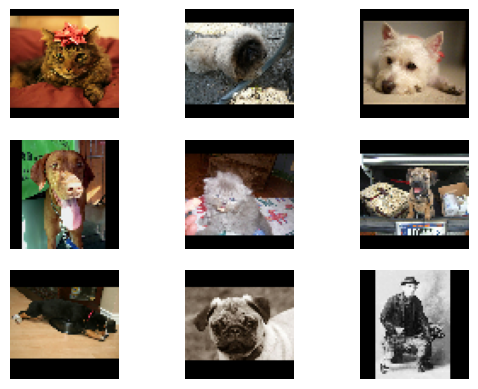

<Figure size 2000x2000 with 0 Axes>

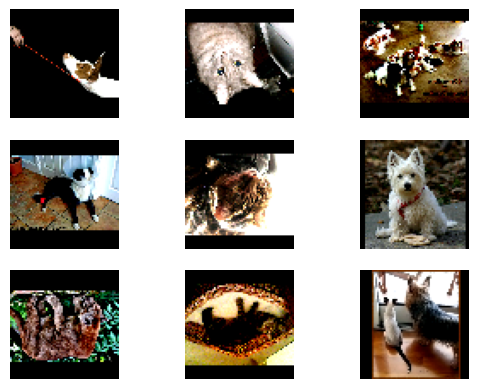

<Figure size 2000x2000 with 0 Axes>

In [24]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal_and_vertical"),
    #layers.RandomRotation(0.1, fill_mode="constant", interpolation="bilinear"),
    layers.RandomContrast(0.4),
    layers.RandomBrightness(0.4),
    layers.Rescaling(1./255)
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

augmented_train_ds = train_ds.map(
    lambda images, labels: (data_augmentation(images), labels))

augmented_val_ds = val_ds.map(
    lambda images, labels: (data_augmentation(images), labels))

for batch_images, _ in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(keras.utils.array_to_img(batch_images[i]))
        plt.axis("off")
plt.figure(figsize=(20, 20))
plt.show()

for batch_images, _ in augmented_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(keras.utils.array_to_img(batch_images[i]))
        plt.axis("off")
plt.figure(figsize=(20, 20))
plt.show()


Dann bauen wir ein einfaches CNN. Durch Keras util Funktionen können wir zusätzlich das Modell graphisch anzeigen lassen.

In [31]:
METRICS = [
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.F1Score(name="f1"),
    keras.metrics.BinaryAccuracy(name="accuracy") if NUMBER_OF_CLASSES == 1 else keras.metrics.CategoricalAccuracy(name="accuracy"),
]


def build_cnn_model():
    output = keras.Sequential()
    output.add(layers.InputLayer(shape=INPUT_SHAPE))
    
    for size in [32, 64, 128, 256]:
        output.add(layers.Conv2D(size, kernel_size=(3, 3), activation="relu"))
        output.add(layers.BatchNormalization())
        output.add(layers.MaxPooling2D(pool_size=(2, 2)))
        output.add(layers.Dropout(0.2))
            
    output.add(layers.Flatten())
    output.add(layers.Dense(512, activation="relu"))
    output.add(layers.BatchNormalization())
    output.add(layers.Dropout(0.2))
    
    output.add(layers.Dense(NUMBER_OF_CLASSES, activation=None))
    
    if NUMBER_OF_CLASSES == 1:
        output.compile(
            optimizer=keras.optimizers.Adam(0.005),
            loss=keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=METRICS,
        )
    else:
        output.compile(
            optimizer=keras.optimizers.Adam(0.005),
            loss=keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics=METRICS,
        )
    
    return output

model = build_cnn_model()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 917,697 (3.50 MB)

 Trainable params: 915,713 (3.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

Training mit Live-Plots

In [21]:
early_stop_cb = keras.callbacks.EarlyStopping(min_delta=0.01, patience=5, restore_best_weights=True, monitor="val_accuracy", mode="max")
# TODO: lrscheduler

history = model.fit(
    augmented_train_ds,
    validation_data=augmented_val_ds,
    epochs=20,
    callbacks=[PlotLossesKeras(), early_stop_cb],
)

accuracy
	training         	 (min:    0.508, max:    0.508, cur:    0.508)
	validation       	 (min:    0.530, max:    0.530, cur:    0.530)
f1
	training         	 (min:    0.666, max:    0.666, cur:    0.666)
	validation       	 (min:    0.669, max:    0.669, cur:    0.669)
Loss
	training         	 (min:    0.885, max:    0.885, cur:    0.885)
	validation       	 (min:    0.748, max:    0.748, cur:    0.748)
precision
	training         	 (min:    0.514, max:    0.514, cur:    0.514)
	validation       	 (min:    0.523, max:    0.523, cur:    0.523)
recall
	training         	 (min:    0.275, max:    0.275, cur:    0.275)
	validation       	 (min:    0.754, max:    0.754, cur:    0.754)
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.4945 - f1: 0.6674 - loss: 1.2219 - precision: 0.4947 - recall: 0.3320 - val_accuracy: 0.5300 - val_f1: 0.6694 - val_loss: 0.7479 - val_precision: 0.5228 - val_recall: 0.7540
Epoch 2/20
 91/200 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5074 - f1

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for i, metric in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])